#### Version history
* V1 - Inference with basic model trained 1000 iterations
* V2 - Same training procedure but for more iterations. Validation score .267, LB score .286
* V3 - Same model weights as previously, but score thresholds set for each class individually. LB score .293 *
* V4 - Another small inference time improvement - throw away predictions with area smaller than a threshold (set per cell type). LB score .294

\* *Initally that version had score .287 but that was due to a bug in the code*

## Inference and submission
After [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) and [part two](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-2-3-training) we have a trained model. I'm attaching it to this notebook through a dataset. Now all that's left is to run all the test files through it.

There are two minor details we need to handle:
- The submission notebooks don't have access to the internet, in order to install detectron2 I needed to download dependecies with `pip download`, put them into a dataset and attach it to the notebook: https://www.kaggle.com/slawekbiel/detectron-05
- The masks we submit can't overlap, see [the discussion](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790#1550666). So I'm manually clipping the output returned from the model) I'm processing the masks ordereded by score, so in the case of conflict the more confident one remaines whole and the other one gets clipped.

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272233 sha256=f17f537c7278a97d616e45de08bb3be72455f80095d33c0386775cadbaa5b331
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *

In [3]:
df_train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
df_instances = df_train.groupby(['id']).agg({'annotation': 'count', 'cell_type': 'first'})
df_instances = df_instances.groupby("cell_type")[['annotation']]\
                               .describe(percentiles=[0.1, 0.25, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]).astype(int)\
                               .T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_instances
df_train['n_pixels'] = df_train.annotation.apply(lambda x: np.sum([int(e) for e in x.split()[1:][::2]]))
df_pixels = df_train.groupby("cell_type")[['n_pixels']].describe(percentiles=[0.02, 0.05, 0.1, 0.9, 0.95, 0.98])\
                    .astype(int).T.droplevel(level=0).T.drop(['count', '50%', 'std'], axis=1)
df_pixels

,mean,min,2%,5%,10%,90%,95%,98%,max
cell_type,,,,,,,,,
astro,905,37,136,185,251,1799,2380,3447,13327
cort,240,33,74,95,114,404,497,624,2054
shsy5y,224,30,59,77,96,393,478,593,2254


In [4]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')

In [5]:
from torchvision.models import resnet34
from torch import nn
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
m = resnet34(False)
m.fc = nn.Linear(512, 3)

classifier = torch.load('../input/sartorius-resnet-34-classifier-finetuned/resnet34-finetuned.bin', map_location='cpu')
classifier.to(DEVICE)
classifier.eval();

In [6]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    
    cell_type = get_image_cell_type(classifier, str(fn))
    
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    previous_masks = []
    for mask in pred_masks:
        mask = mask * (1-used)
        mask = refine_mask(mask, df_pixels, cell_type)
        mask = remove_overlapping_pixels(mask, previous_masks)
        previous_masks.append(mask)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [7]:
TEST_PATH = '../input/sartorius-cell-instance-segmentation/test'
def get_image_for_classifier(image_id):
    image_path = image_id
    print(image_path)
    transforms = A.Compose([A.Resize(224, 224), 
                       A.Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                       ToTensorV2()])
    image = transforms(image=cv2.imread(image_path))['image']
    return image.unsqueeze(0).to(DEVICE)

# Assess the image_id cell_type with the classifier
def get_image_cell_type(classifier, image_id):
    img = get_image_for_classifier(image_id)
    with torch.no_grad():
        logits = classifier(img)[0]
        cell_type_idx = torch.argmax(logits).item()
    print(cell_type_idx)
    return CELL_TYPES[cell_type_idx]


def refine_mask(mask, df_pixels, cell_type):
    
    
    # Minimum number of pixels:
    # The percentile 0.02 of the cell_type in the train set
    min_pixels = df_pixels.loc[cell_type, '2%']
    # Max number of pixels
    # The percentile 0.95 of the cell_type in the train set
    max_pixels = df_pixels.loc[cell_type, '98%']
    
    binary_mask = mask > MASK_THRESHOLD
    
    # If the mask is too small, make the condition less strict
    # increasing its size until it reaches a minimum number of pixels
    if binary_mask.sum() < min_pixels:
        for t in range(25):
            binary_mask = mask > (MASK_THRESHOLD - t * 0.02)
            if binary_mask.sum() > min_pixels:
                break
    
    # If the mask is too large, make the condition more strict
    # reducing its size until it has less than certain amount of pixels
    if binary_mask.sum() > max_pixels:
        for t in range(25):
            binary_mask = mask > (MASK_THRESHOLD + t * 0.02)
            if binary_mask.sum() < max_pixels:
                break

    return binary_mask


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask


In [8]:
ids, masks=[],[]
test_names = (dataDir/'test').ls()

### Initiate a Predictor from our trained model

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('../input/sartorius-models', "model_2696.pth")  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

../input/sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png
0


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


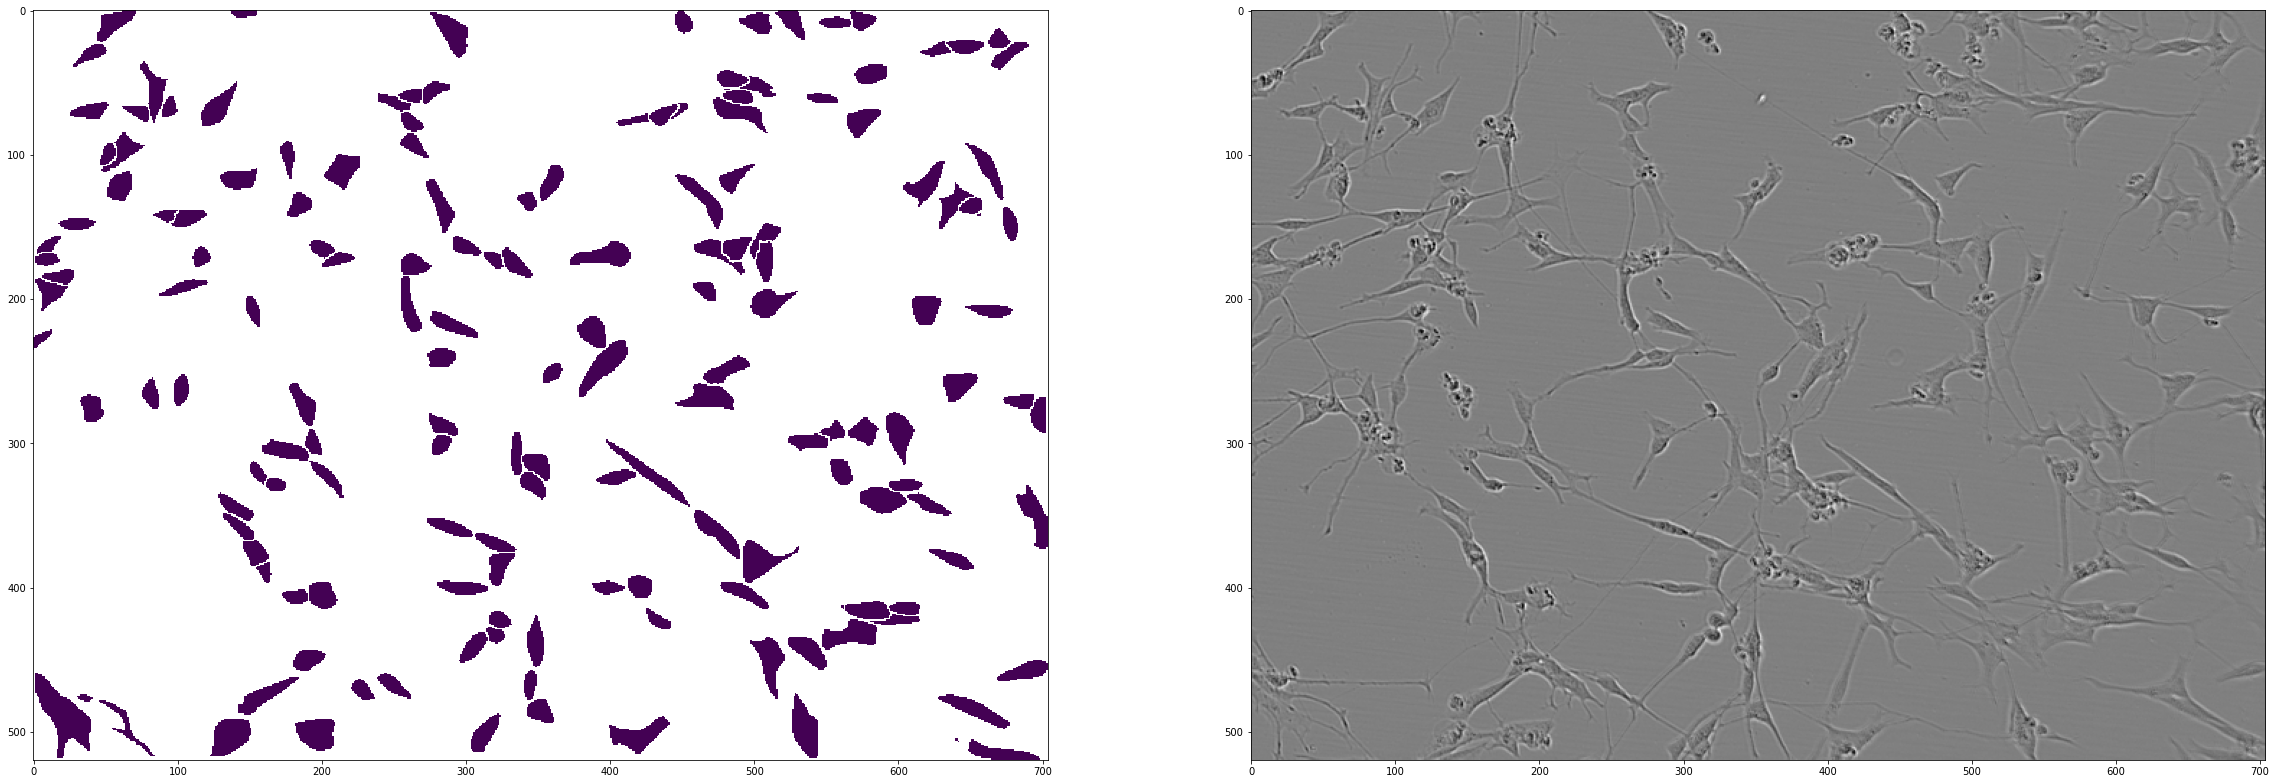

In [10]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)
CELL_TYPES  = {0: 'shsy5y', 1: 'astro', 2: 'cort'}

MIN_SCORE = 0.59

MASK_THRESHOLD = 0.5

# The maximum possible amount of predictions
# 539 is the 90% percentile of the cell_type with more instances per image
BOX_DETECTIONS_PER_IMG = 559
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

### Looks good, so lets generate masks for all the files and create a submission

In [11]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

../input/sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png
0
../input/sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png
1
../input/sartorius-cell-instance-segmentation/test/d48ec7815252.png
1


In [12]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,140004 16 140707 20 141410 21 142114 22 142818...
1,7ae19de7bc2a,322073 3 322776 6 323479 7 324182 9 324886 9 3...
2,7ae19de7bc2a,26628 11 27329 17 28031 19 28733 21 29436 22 3...
3,7ae19de7bc2a,96418 4 97121 6 97825 7 98529 8 99233 9 99937 ...
4,7ae19de7bc2a,224280 7 224979 15 225680 20 226381 23 227083 ...
